In [ ]:
# Check GPU status
!nvidia-smi


Sat Nov  2 11:20:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro P400                    Off | 00000000:2D:00.0  On |                  N/A |
| 34%   37C    P8              N/A /  N/A |    102MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
from sklearn.preprocessing import LabelEncoder


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns
from sklearn.manifold import TSNE


# torch geometrics
import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN
import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.transforms import RandomLinkSplit

from sklearn.metrics import roc_auc_score
# # Grape

2024-11-02 11:20:26.003065: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 11:20:26.051553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 11:20:26.736747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [3]:
# # Grape
# from grape.datasets import get_all_available_graphs_dataframe
# from grape.datasets import get_dataset
from grape import Graph
from grape import GraphVisualizer

# # Ensmallen
# from grape.embedders import Node2VecCBOWEnsmallen, Node2VecGloVeEnsmallen, Node2VecSkipGramEnsmallen
# from grape.embedders import DeepWalkCBOWEnsmallen, DeepWalkGloVeEnsmallen, DeepWalkSkipGramEnsmallen
# from grape.embedders import WalkletsSkipGramEnsmallen, WalkletsCBOWEnsmallen, WalkletsGloVeEnsmallen
# from grape.embedders import FirstOrderLINEEnsmallen, SecondOrderLINEEnsmallen
# #from grape.embedders import NetMFEnsmallen, GLEEEnsmallen, HOPEEnsmallen
from grape.embedders import TransEEnsmallen

# # TensorFlow
# from grape.embedders import SkipGramTensorFlow, CBOWTensorFlow
# from grape.embedders import FirstOrderLINETensorFlow, SecondOrderLINETensorFlow

# # KarateClub
# from grape.embedders import Role2VecKarateClub, GraRepKarateClub
# from grape.embedders import NMFADMMKarateClub, RandNEKarateClub


# # Edge prediction evaluation
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

# from grape.edge_prediction import KipfGCNEdgePrediction

# # Node Label prediction evaluation
# from grape.node_label_prediction import node_label_prediction_evaluation
# from grape.node_label_prediction import DecisionTreeNodeLabelPrediction, RandomForestNodeLabelPrediction, MLPNodeLabelPrediction, GradientBoostingNodeLabelPrediction#, PerceptronNodeLabelPrediction

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Load graph
view=1
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/home/mayank/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [6]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [9]:
# IMPORT METHODS

# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [10]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [11]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

# train_data = Data(x=nodes_x,
#                   edge_index=edge_index, edge_type=edge_type,
#                   edge_label_index=edge_index,
#                   edge_label=torch.ones(edge_index.size(1))
#                     )

# train_data = train_data.to(device)

In [12]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

transform = RandomLinkSplit(is_undirected=False)

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
test_data = test_data.to(device)
val_data = val_data.to(device)

In [13]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 2365462  Test:675846  Validation: 337922


In [14]:
# Model

model = DistMult(
    num_nodes=train_data.num_nodes,
    num_relations=train_data.num_edge_types,
    hidden_channels=50, # The hidden embedding size.
).to(device)

loader = model.loader(
    head_index=train_data.edge_index[0],
    rel_type=train_data.edge_type,
    tail_index=train_data.edge_index[1],
    batch_size=1000,
    shuffle=True,
)

optimizer =  optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

# ALTERNATIVE MODELS

# model_map = {
#     'transe': TransE,
#     'complex': ComplEx,
#     'distmult': DistMult,
#     'rotate': RotatE,
# }

# Proposed configurations
# optimizer_map = {
#     'transe': optim.Adam(model.parameters(), lr=0.01),
#     'complex': optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6),
#     'distmult': optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6),
#     'rotate': optim.Adam(model.parameters(), lr=1e-3),
# }

In [15]:
# Training definitions

def train():
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples


@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=data.edge_index[0],
        rel_type=data.edge_type,
        tail_index=data.edge_index[1],
        batch_size=20000,
        k=10,
    )

@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

In [ ]:
# Training
n_epochs=26

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.9962
Epoch: 002, Loss: 0.8649
Epoch: 003, Loss: 0.5204
Epoch: 004, Loss: 0.3171
Epoch: 005, Loss: 0.2458
Epoch: 006, Loss: 0.2136
Epoch: 007, Loss: 0.1959
Epoch: 008, Loss: 0.1838
Epoch: 009, Loss: 0.1740
Epoch: 010, Loss: 0.1671
Epoch: 011, Loss: 0.1618
Epoch: 012, Loss: 0.1564
Epoch: 013, Loss: 0.1531
Epoch: 014, Loss: 0.1483
Epoch: 015, Loss: 0.1449
Epoch: 016, Loss: 0.1419
Epoch: 017, Loss: 0.1396
Epoch: 018, Loss: 0.1366
Epoch: 019, Loss: 0.1348
Epoch: 020, Loss: 0.1320
Epoch: 021, Loss: 0.1295
Epoch: 022, Loss: 0.1288
Epoch: 023, Loss: 0.1258
Epoch: 024, Loss: 0.1249
Epoch: 025, Loss: 0.1241


100%|██████████| 1182731/1182731 [27:17<00:00, 722.45it/s]


Epoch: 025, Val Mean Rank: 5060.84, Val MRR: 0.0116, Val Hits@10: 0.0221


In [ ]:
# Training
n_epochs=26

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.1221
Epoch: 002, Loss: 0.1213
Epoch: 003, Loss: 0.1200
Epoch: 004, Loss: 0.1188
Epoch: 005, Loss: 0.1183
Epoch: 006, Loss: 0.1182
Epoch: 007, Loss: 0.1170
Epoch: 008, Loss: 0.1156
Epoch: 009, Loss: 0.1155
Epoch: 010, Loss: 0.1146
Epoch: 011, Loss: 0.1141
Epoch: 012, Loss: 0.1130
Epoch: 013, Loss: 0.1126
Epoch: 014, Loss: 0.1114
Epoch: 015, Loss: 0.1113
Epoch: 016, Loss: 0.1114
Epoch: 017, Loss: 0.1106
Epoch: 018, Loss: 0.1102
Epoch: 019, Loss: 0.1094
Epoch: 020, Loss: 0.1091
Epoch: 021, Loss: 0.1085
Epoch: 022, Loss: 0.1083
Epoch: 023, Loss: 0.1073
Epoch: 024, Loss: 0.1072
Epoch: 025, Loss: 0.1072


100%|██████████| 1182731/1182731 [27:16<00:00, 722.85it/s]


Epoch: 025, Val Mean Rank: 4743.84, Val MRR: 0.0132, Val Hits@10: 0.0241


In [ ]:
# Testing
rank, mrr, hits_at_10 = test(test_data)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
 f'Test Hits@10: {hits_at_10:.4f}')

100%|██████████| 1351692/1351692 [31:12<00:00, 722.03it/s]


Test Mean Rank: 4921.63, Test MRR: 0.0130, Test Hits@10: 0.0238


In [16]:
## EXTERNAL TEST SETS

## VIEW 0-2
test_sets = ['miRNA-disease2bepred']
test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
#test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
#test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.txt", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test-.txt",names=["subject","predicate","object"], sep='\t')

In [17]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 12], [True, 16900]]


In [ ]:
rank, mrr, hits_at_10 = test(external_test_data)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
 f'Test Hits@10: {hits_at_10:.4f}')

100%|██████████| 16900/16900 [00:24<00:00, 695.82it/s]

Test Mean Rank: 14532.97, Test MRR: 0.0237, Test Hits@10: 0.0543


In [18]:
node_embedding = pd.DataFrame(model.node_emb.weight.cpu().detach().numpy())

label_encoder = LabelEncoder()
node_types = label_encoder.fit_transform(list(nodes_df.type))
node_embedding.index = nodes_df
len(node_embedding)

85064

In [ ]:
node_embedding

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
"(<http://purl.obolibrary.org/obo/MONDO_0007247>, Disease)",-0.016666,0.074703,4.907619e-39,-0.018454,0.073584,0.018870,-0.072033,0.015444,0.016506,0.074672,...,-0.009475,-4.904683e-39,-0.072779,-0.074589,-0.075350,-0.015846,-0.073678,-0.075239,0.020576,-0.018881
"(<https://www.mirbase.org/mature/MIMAT0015042>, miRNA)",-0.224474,-0.177604,-4.910701e-39,-0.221514,-0.176680,0.223534,0.171684,0.226191,0.229471,-0.177892,...,-0.228161,4.908042e-39,0.179080,0.176085,0.174156,-0.217468,0.170767,0.172484,0.226914,-0.220907
"(<http://purl.obolibrary.org/obo/UBERON_0002195>, Anatomy)",0.032339,0.018368,4.912923e-39,0.030425,0.015761,-0.031914,-0.013184,-0.028955,-0.033350,0.019274,...,0.038326,-4.909620e-39,-0.013808,-0.016049,-0.014920,0.037158,-0.017778,-0.017193,-0.029119,0.032414
"(<http://purl.obolibrary.org/obo/MONDO_0004583>, Disease)",-0.034127,0.078363,4.914239e-39,-0.031420,0.076875,0.031143,-0.076925,0.031198,0.032771,0.078259,...,-0.038161,-4.911285e-39,-0.077016,-0.076375,-0.077645,-0.039025,-0.077188,-0.076514,0.029426,-0.035207
"(<http://purl.obolibrary.org/obo/GO_0060761>, GO)",-0.019613,0.094472,4.904725e-39,-0.012273,0.092726,0.016929,-0.092653,0.016332,0.024548,0.094269,...,-0.021435,4.916400e-39,-0.091858,-0.092735,-0.093055,-0.022697,-0.092826,-0.095622,0.014766,-0.016632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(<http://purl.obolibrary.org/obo/MONDO_0010781>, Disease)",-0.085564,0.013814,4.917308e-39,-0.084308,0.013906,0.083875,-0.010262,0.081621,0.091566,0.014423,...,-0.089143,4.906806e-39,-0.013478,-0.014655,-0.014620,-0.087436,-0.014295,-0.013417,0.084639,-0.084671
"(<http://purl.obolibrary.org/obo/HP_0100454>, Phenotype)",-0.003521,-0.016101,-4.915217e-39,-0.002967,-0.015555,0.002752,0.016235,0.003648,0.002906,-0.015356,...,0.001529,-4.910055e-39,0.016092,0.014906,0.016405,-0.001913,0.015200,0.015735,0.003606,-0.004695
"(<http://www.ncbi.nlm.nih.gov/gene/57101>, Gene)",0.092226,-0.074107,-4.907400e-39,0.093319,-0.069150,-0.091714,0.072948,-0.090777,-0.091848,-0.071344,...,0.097701,4.916468e-39,0.080790,0.076758,0.075388,0.092650,0.075290,0.076332,-0.087944,0.086763
"(<http://www.ncbi.nlm.nih.gov/gene/51316>, Gene)",0.116423,-0.108937,-4.904945e-39,0.113027,-0.104269,-0.117980,0.107254,-0.113685,-0.118893,-0.103822,...,0.118855,-4.909289e-39,0.109254,0.109475,0.107275,0.111082,0.101587,0.102362,-0.120233,0.113880


In [ ]:
!ls -lh


total 8.0K
drwx------ 5 root root 4.0K Jul 28 09:16 drive
drwxr-xr-x 1 root root 4.0K Jul 25 13:21 sample_data


In [ ]:
node_embedding.to_csv('node_embeddings.csv', header=False, index=True, sep=',')

In [ ]:
%matplotlib inline

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

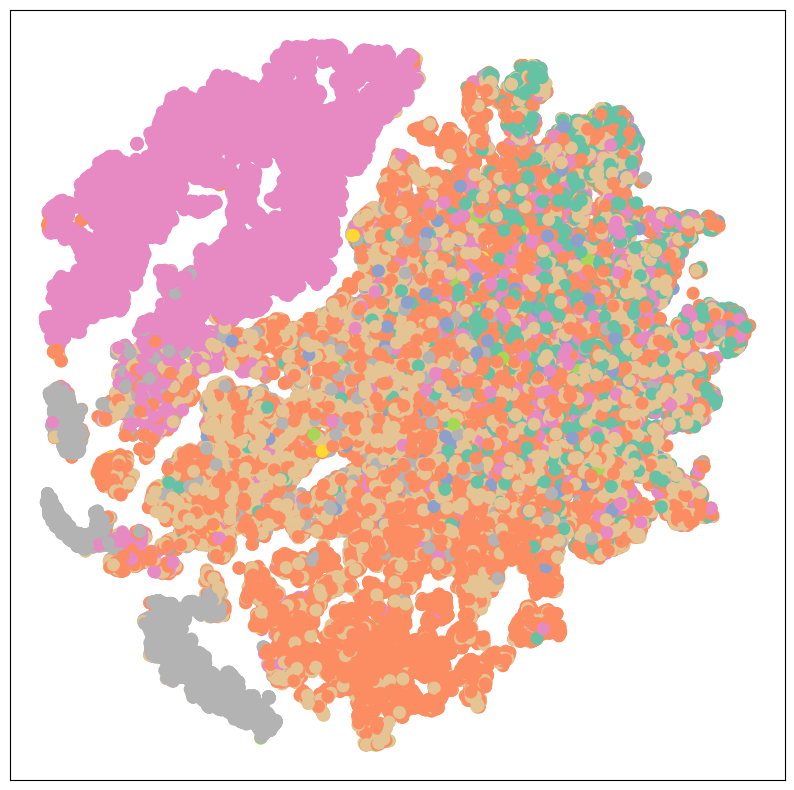

In [ ]:
visualize(node_embedding,node_types)

In [7]:
node_embedding = pd.read_csv('/home/mayank/view1_dismult_node_embeddings.csv', header = None)

In [8]:
node_embedding

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,('<http://purl.obolibrary.org/obo/MONDO_000724...,-0.016666,0.074703,4.907619e-39,-0.018454,0.073584,0.018870,-0.072033,0.015444,0.016506,...,-0.009475,-4.904683e-39,-0.072779,-0.074589,-0.075350,-0.015846,-0.073678,-0.075239,0.020576,-0.018881
1,('<https://www.mirbase.org/mature/MIMAT0015042...,-0.224474,-0.177604,-4.910700e-39,-0.221514,-0.176680,0.223534,0.171684,0.226191,0.229471,...,-0.228161,4.908042e-39,0.179080,0.176085,0.174156,-0.217468,0.170767,0.172484,0.226914,-0.220907
2,('<http://purl.obolibrary.org/obo/UBERON_00021...,0.032339,0.018368,4.912923e-39,0.030425,0.015761,-0.031914,-0.013184,-0.028955,-0.033350,...,0.038326,-4.909620e-39,-0.013808,-0.016049,-0.014920,0.037158,-0.017778,-0.017193,-0.029119,0.032414
3,('<http://purl.obolibrary.org/obo/MONDO_000458...,-0.034127,0.078363,4.914239e-39,-0.031420,0.076875,0.031143,-0.076925,0.031198,0.032771,...,-0.038161,-4.911285e-39,-0.077016,-0.076375,-0.077645,-0.039025,-0.077188,-0.076514,0.029426,-0.035207
4,('<http://purl.obolibrary.org/obo/GO_0060761>'...,-0.019613,0.094472,4.904725e-39,-0.012273,0.092726,0.016929,-0.092653,0.016332,0.024548,...,-0.021435,4.916400e-39,-0.091858,-0.092735,-0.093055,-0.022697,-0.092826,-0.095622,0.014766,-0.016632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85059,('<http://purl.obolibrary.org/obo/MONDO_001078...,-0.085564,0.013814,4.917308e-39,-0.084308,0.013906,0.083875,-0.010262,0.081621,0.091566,...,-0.089143,4.906806e-39,-0.013478,-0.014655,-0.014620,-0.087436,-0.014295,-0.013417,0.084639,-0.084671
85060,('<http://purl.obolibrary.org/obo/HP_0100454>'...,-0.003521,-0.016101,-4.915217e-39,-0.002967,-0.015555,0.002752,0.016235,0.003648,0.002906,...,0.001529,-4.910055e-39,0.016092,0.014906,0.016405,-0.001913,0.015200,0.015735,0.003606,-0.004695
85061,"('<http://www.ncbi.nlm.nih.gov/gene/57101>', '...",0.092226,-0.074107,-4.907400e-39,0.093319,-0.069150,-0.091714,0.072948,-0.090777,-0.091848,...,0.097701,4.916468e-39,0.080790,0.076758,0.075388,0.092650,0.075290,0.076332,-0.087944,0.086763
85062,"('<http://www.ncbi.nlm.nih.gov/gene/51316>', '...",0.116423,-0.108937,-4.904945e-39,0.113027,-0.104269,-0.117980,0.107254,-0.113685,-0.118893,...,0.118855,-4.909290e-39,0.109254,0.109475,0.107275,0.111082,0.101587,0.102362,-0.120233,0.113880


In [9]:
node_embedding.set_index(node_embedding.columns[0], inplace=True)

In [10]:
node_embedding.values

array([[-1.66663210e-02,  7.47026100e-02,  4.90761900e-39, ...,
        -7.52385260e-02,  2.05763450e-02, -1.88813300e-02],
       [-2.24474270e-01, -1.77604050e-01, -4.91070000e-39, ...,
         1.72484070e-01,  2.26914150e-01, -2.20906720e-01],
       [ 3.23390960e-02,  1.83677820e-02,  4.91292300e-39, ...,
        -1.71932760e-02, -2.91189890e-02,  3.24143170e-02],
       ...,
       [ 9.22263860e-02, -7.41073200e-02, -4.90740000e-39, ...,
         7.63319700e-02, -8.79436660e-02,  8.67631960e-02],
       [ 1.16422996e-01, -1.08937010e-01, -4.90494500e-39, ...,
         1.02361890e-01, -1.20232540e-01,  1.13880046e-01],
       [ 7.61789800e-02, -6.51864900e-02, -4.91560600e-39, ...,
         6.60838700e-02, -7.49391500e-02,  7.63836500e-02]])

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, node_types):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    unique_node_types = np.unique(node_types)
    palette = sns.color_palette("tab20", len(unique_node_types))

    # Create a dictionary mapping each node type to a color
    node_type_to_color = {node_type: palette[i] for i, node_type in enumerate(unique_node_types)}

    # Map the colors for each node based on its type
    node_colors = [node_type_to_color[node_type] for node_type in node_types]
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")




    # Create legend manually
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
               for color in palette]
    plt.legend(handles, unique_node_types, title="Node Types", loc='best')
    plt.show()

/tmp/ipykernel_477311/1780641566.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")


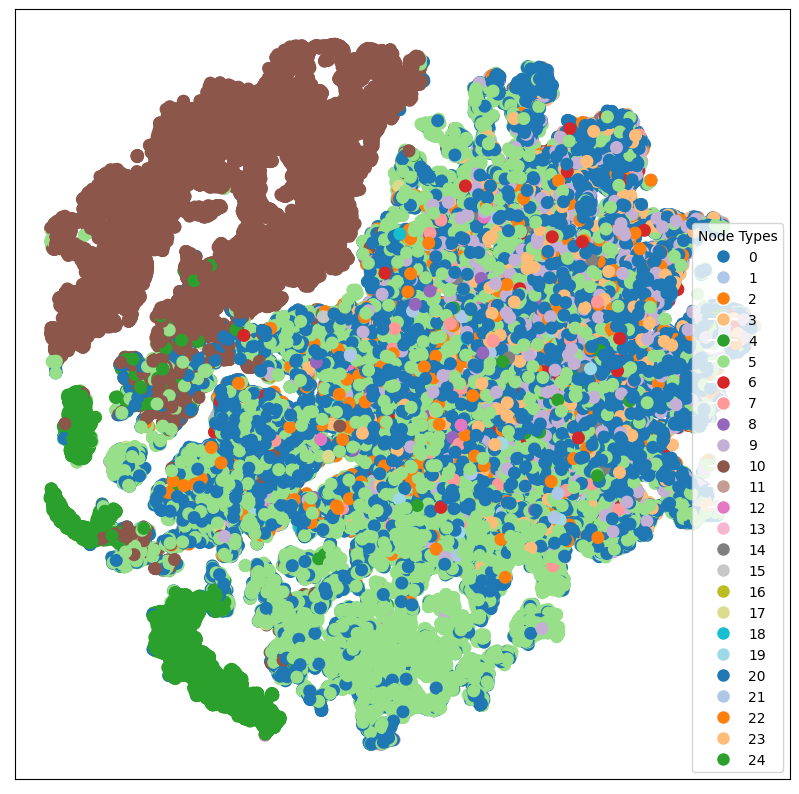

In [24]:
visualize(node_embedding.values,node_types)

In [16]:
node_embeddings = pd.read_csv('/content/drive/MyDrive/models_thesis/mayank/view1_dismult_node_embeddings.csv', header= None)

In [17]:
node_embeddings

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,('<http://purl.obolibrary.org/obo/MONDO_000724...,-0.016666,0.074703,4.907619e-39,-0.018454,0.073584,0.018870,-0.072033,0.015444,0.016506,...,-0.009475,-4.904683e-39,-0.072779,-0.074589,-0.075350,-0.015846,-0.073678,-0.075239,0.020576,-0.018881
1,('<https://www.mirbase.org/mature/MIMAT0015042...,-0.224474,-0.177604,-4.910700e-39,-0.221514,-0.176680,0.223534,0.171684,0.226191,0.229471,...,-0.228161,4.908042e-39,0.179080,0.176085,0.174156,-0.217468,0.170767,0.172484,0.226914,-0.220907
2,('<http://purl.obolibrary.org/obo/UBERON_00021...,0.032339,0.018368,4.912923e-39,0.030425,0.015761,-0.031914,-0.013184,-0.028955,-0.033350,...,0.038326,-4.909620e-39,-0.013808,-0.016049,-0.014920,0.037158,-0.017778,-0.017193,-0.029119,0.032414
3,('<http://purl.obolibrary.org/obo/MONDO_000458...,-0.034127,0.078363,4.914239e-39,-0.031420,0.076875,0.031143,-0.076925,0.031198,0.032771,...,-0.038161,-4.911285e-39,-0.077016,-0.076375,-0.077645,-0.039025,-0.077188,-0.076514,0.029426,-0.035207
4,('<http://purl.obolibrary.org/obo/GO_0060761>'...,-0.019613,0.094472,4.904725e-39,-0.012273,0.092726,0.016929,-0.092653,0.016332,0.024548,...,-0.021435,4.916400e-39,-0.091858,-0.092735,-0.093055,-0.022697,-0.092826,-0.095622,0.014766,-0.016632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85059,('<http://purl.obolibrary.org/obo/MONDO_001078...,-0.085564,0.013814,4.917308e-39,-0.084308,0.013906,0.083875,-0.010262,0.081621,0.091566,...,-0.089143,4.906806e-39,-0.013478,-0.014655,-0.014620,-0.087436,-0.014295,-0.013417,0.084639,-0.084671
85060,('<http://purl.obolibrary.org/obo/HP_0100454>'...,-0.003521,-0.016101,-4.915217e-39,-0.002967,-0.015555,0.002752,0.016235,0.003648,0.002906,...,0.001529,-4.910055e-39,0.016092,0.014906,0.016405,-0.001913,0.015200,0.015735,0.003606,-0.004695
85061,"('<http://www.ncbi.nlm.nih.gov/gene/57101>', '...",0.092226,-0.074107,-4.907400e-39,0.093319,-0.069150,-0.091714,0.072948,-0.090777,-0.091848,...,0.097701,4.916468e-39,0.080790,0.076758,0.075388,0.092650,0.075290,0.076332,-0.087944,0.086763
85062,"('<http://www.ncbi.nlm.nih.gov/gene/51316>', '...",0.116423,-0.108937,-4.904945e-39,0.113027,-0.104269,-0.117980,0.107254,-0.113685,-0.118893,...,0.118855,-4.909290e-39,0.109254,0.109475,0.107275,0.111082,0.101587,0.102362,-0.120233,0.113880


In [21]:
node_embeddings.set_index(node_embeddings.columns[0], inplace=True)

In [22]:
node_embeddings.values

array([[-1.66663210e-02,  7.47026100e-02,  4.90761900e-39, ...,
        -7.52385260e-02,  2.05763450e-02, -1.88813300e-02],
       [-2.24474270e-01, -1.77604050e-01, -4.91070000e-39, ...,
         1.72484070e-01,  2.26914150e-01, -2.20906720e-01],
       [ 3.23390960e-02,  1.83677820e-02,  4.91292300e-39, ...,
        -1.71932760e-02, -2.91189890e-02,  3.24143170e-02],
       ...,
       [ 9.22263860e-02, -7.41073200e-02, -4.90740000e-39, ...,
         7.63319700e-02, -8.79436660e-02,  8.67631960e-02],
       [ 1.16422996e-01, -1.08937010e-01, -4.90494500e-39, ...,
         1.02361890e-01, -1.20232540e-01,  1.13880046e-01],
       [ 7.61789800e-02, -6.51864900e-02, -4.91560600e-39, ...,
         6.60838700e-02, -7.49391500e-02,  7.63836500e-02]])

In [11]:
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [12]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [29]:
# Assuming node_embedding index is a tuple of (URI, type)
node_embedding.index = [name[0] for name in node_embedding.index]

In [30]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=node_embedding.values,  # Use simplified embedding features
    smoke_test=False,
    enable_cache=False
)

Evaluating on VIEW1_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

In [31]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINEv1d.csv"
results.to_csv(filename)

In [32]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,false_omission_rate,precision,balanced_accuracy,fall_out,specificity,prevalence_threshold,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.800001,1.0,True,0.190275,0.521783,0.540704,0.893587,0.106413,0.489103,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.800001,1.0,True,0.174416,0.522533,0.542149,0.893123,0.106877,0.488728,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.800001,1.0,True,0.189748,0.521984,0.541058,0.892774,0.107226,0.489003,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.800001,1.0,True,0.173822,0.522663,0.542381,0.892653,0.107347,0.488663,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.800001,1.0,True,0.191947,0.521520,0.540230,0.894473,0.105527,0.489235,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.800001,1.0,True,0.177947,0.522137,0.541427,0.894257,0.105743,0.488926,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.800001,1.0,True,0.188167,0.522200,0.541450,0.892089,0.107911,0.488894,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.800001,1.0,True,0.173389,0.522763,0.542560,0.892286,0.107714,0.488613,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.800001,1.0,True,0.188435,0.522070,0.541221,0.892629,0.107371,0.488960,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.800001,1.0,True,0.177300,0.522342,0.541791,0.893458,0.106542,0.488823,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None


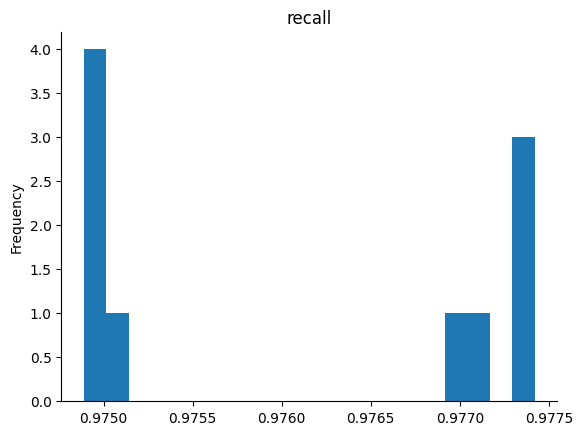

In [33]:
from matplotlib import pyplot as plt
results['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

In [15]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[DecisionTreeEdgePrediction()],
    number_of_holdouts=5,
    node_features= node_embedding.values,  # Use simplified embedding features
    smoke_test=False
)

Evaluating on VIEW1_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

In [16]:
results = evaluation
filename = "results_"+view_name+"DesicionTree_V1Distmult.csv"
results.to_csv(filename)

In [17]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,markedness,specificity,precision,accuracy,balanced_accuracy,prevalence,...,"(model_parameters, criterion)","(model_parameters, splitter)","(model_parameters, max_depth)","(model_parameters, min_samples_split)","(model_parameters, min_samples_leaf)","(model_parameters, min_weight_fraction_leaf)","(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, ccp_alpha)"
0,train,0.800001,1.0,True,0.261393,0.122006,0.521553,0.539552,0.539552,0.5,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.271952,0.122200,0.522161,0.540711,0.540711,0.5,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.221954,0.073154,0.511426,0.521675,0.521675,0.5,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.244131,0.073064,0.512185,0.523153,0.523153,0.5,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.262441,0.092180,0.516209,0.530416,0.530416,0.5,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.277142,0.092160,0.516796,0.531556,0.531556,0.5,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.151375,0.107665,0.512760,0.523369,0.523369,0.5,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.155201,0.107483,0.512987,0.523801,0.523801,0.5,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.317258,0.114801,0.522926,0.542539,0.542539,0.5,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.330027,0.114435,0.523410,0.543500,0.543500,0.5,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0


In [18]:
# Separate train and test results
train_results = evaluation[evaluation['evaluation_mode'] == 'train']
test_results = evaluation[evaluation['evaluation_mode'] == 'test']

# Function to compute mean metrics for a given evaluation mode
def compute_mean_metrics(data):
    results = []
    for holdout in data['holdout_number'].unique():
        holdout_data = data[data['holdout_number'] == holdout]

        # Calculate mean values for metrics
        auc_score = holdout_data['auroc'].mean()
        precision = holdout_data['precision'].mean()
        recall = holdout_data['recall'].mean()
        f1_score = holdout_data['f1_score'].mean()
        accuracy = holdout_data['accuracy'].mean()  # Assuming 'accuracy' column exists

        # Append results for this holdout
        results.append({
            'Holdout': holdout,
            'AUC': auc_score,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Accuracy': accuracy
        })

    # Convert to DataFrame
    return pd.DataFrame(results)

# Compute metrics for train and test
train_metrics_df = compute_mean_metrics(train_results)
test_metrics_df = compute_mean_metrics(test_results)

# Calculate overall mean for train and test
overall_train_mean = train_metrics_df.mean(numeric_only=True)
overall_test_mean = test_metrics_df.mean(numeric_only=True)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Evaluation Mode': ['Train', 'Test'],
    'AUC': [overall_train_mean['AUC'], overall_test_mean['AUC']],
    'Precision': [overall_train_mean['Precision'], overall_test_mean['Precision']],
    'Recall': [overall_train_mean['Recall'], overall_test_mean['Recall']],
    'F1 Score': [overall_train_mean['F1 Score'], overall_test_mean['F1 Score']],
    'Accuracy': [overall_train_mean['Accuracy'], overall_test_mean['Accuracy']]
})

# Display the summary of mean metrics
print(summary_df)

  Evaluation Mode       AUC  Precision    Recall  F1 Score  Accuracy
0           Train  0.607688   0.516975  0.961059  0.672276  0.531510
1            Test  0.627113   0.517508  0.963220  0.673254  0.532544


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = node_embeddings.values
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.6332
Precision: 0.6017
Recall: 0.6332


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

selected_classes = ['miRNA', 'Gene', 'Disease']

filtered_embeddings = []
filtered_labels = []


for class_label in selected_classes:

    class_indices = nodes_df[nodes_df['type'] == class_label].index


    class_embeddings = node_embedding.iloc[class_indices, 1:].values  # Skip the first column with identifiers

    # Append the filtered embeddings and labels
    filtered_embeddings.append(class_embeddings)
    filtered_labels.extend([class_label] * len(class_embeddings))


X_filtered = np.vstack(filtered_embeddings)

# Encode the labels
le = LabelEncoder()
y_filtered = le.fit_transform(filtered_labels)  # Convert the labels into numerical form


X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

precision_per_class = precision_score(y_test, y_pred, average=None, labels=np.unique(y_filtered))
recall_per_class = recall_score(y_test, y_pred, average=None, labels=np.unique(y_filtered))

for i, class_label in enumerate(le.classes_):
    if class_label in selected_classes:
        print(f"Class: {class_label}")
        print(f"  Precision: {precision_per_class[i]:.4f}")
        print(f"  Recall: {recall_per_class[i]:.4f}")


Accuracy: 0.9752
Precision: 0.9752
Recall: 0.9752
Class: Disease
  Precision: 0.9815
  Recall: 0.9848
Class: Gene
  Precision: 0.9704
  Recall: 0.9774
Class: miRNA
  Precision: 0.9625
  Recall: 0.9173


In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the labels
true_labels = nodes_df['type']
X =  node_embedding.values

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(true_labels)  # Convert the labels into numerical form

class_distribution = np.bincount(y)
print("Class distribution:", dict(zip(le.classes_, class_distribution)))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42,  class_weight='balanced')
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and f1-score for each class (node type)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Print the overall accuracy
print(f"Overall Accuracy: {accuracy:.4f}")

for i, class_label in enumerate(le.classes_):
    try:
        precision_class = precision_score(y_test, y_pred, labels=[i], average='macro')
        recall_class = recall_score(y_test, y_pred, labels=[i], average='macro')
        f1_class = f1_score(y_test, y_pred, labels=[i], average='macro')
        print(f"Class: {class_label}")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1 Score: {f1[i]:.4f}")
    except IndexError:
        print(f"Class: {class_label}")
        print("  Precision: 0.0000 (No predictions for this class)")
        print("  Recall: 0.0000")
        print("  F1 Score: 0.0000")

Class distribution: {'Anatomy': 6084, 'Basic formal': 1, 'Cell': 1272, 'Chemical': 2239, 'Chromosome': 310, 'Disease': 24203, 'Environment': 453, 'Environmental exposure': 419, 'Food': 181, 'GO': 4050, 'Gene': 19517, 'General medical science': 6, 'Genomic feature': 98, 'Human developmental stage': 72, 'Medical action': 114, 'Mental disease': 12, 'Mental functioning': 14, 'Mouse pathology': 75, 'NCI thesaurus': 84, 'Neuro behaviour': 153, 'Phenotype': 19152, 'Protein': 205, 'Species': 1784, 'Vaccine': 1, 'miRNA': 4565}


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Overall Accuracy: 0.6280
Class: Anatomy
  Precision: 0.3000
  Recall: 0.3290
  F1 Score: 0.3138


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class: Basic formal
  Precision: 0.3333
  Recall: 0.0025
  F1 Score: 0.0049
Class: Cell
  Precision: 0.2182
  Recall: 0.0173
  F1 Score: 0.0321
Class: Chemical
  Precision: 1.0000
  Recall: 0.0349
  F1 Score: 0.0674
Class: Chromosome
  Precision: 0.6171
  Recall: 0.6943
  F1 Score: 0.6534
Class: Disease
  Precision: 1.0000
  Recall: 0.0075
  F1 Score: 0.0149
Class: Environment
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Environmental exposure
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Food
  Precision: 0.2773
  Recall: 0.0917
  F1 Score: 0.1378


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class: GO
  Precision: 0.9648
  Recall: 0.9786
  F1 Score: 0.9717
Class: Gene
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class: General medical science
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Genomic feature
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class: Human developmental stage
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Medical action
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class: Mental disease
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Mental functioning
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Mouse pathology
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class: NCI thesaurus
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Neuro behaviour
  Precision: 0.4352
  Recall: 0.5815
  F1 Score: 0.4978
Class: Phenotype
  Precision: 1.0000
  Recall: 0.0455
  F1 Score: 0.0870
Class: Protein
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Species
  Precision: 0.9538
  Recall: 0.9123
  F1 Score: 0.9326
Class: Vaccine
Class: Vaccine
  Precision: 0.0000 (No predictions for this class)
  Recall: 0.0000
  F1 Score: 0.0000
Class: miRNA
Class: miRNA
  Precision: 0.0000 (No predictions for this class)
  Recall: 0.0000
  F1 Score: 0.0000


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
